In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
EOS_token = 0
SOS_token = 1

class Lang:
    def __init__(self,name):
        
        self.name = name
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {0:'EOS',1:'SOS'}
        self.num_words = 2
        
    def add_sentence(self,sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self,word):
        if word not in self.word2idx:
            self.word2idx[word] = self.num_words
            self.word2count[word] = 1
            self.idx2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            

In [3]:
france = Lang('france')


In [4]:
france


In [5]:
#Helper functions!
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



# Read Data

In [6]:
def read_lang(path,lang1,lang2,reverse =False):
    print('Starting ! ! !')
    lines = open(path +'%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
     # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs



In [7]:
class EncodeRNN(nn.Module):
    
    def __init__(self,input_size,hidden_size):
        super(EncodeRNN,self).__init__()
        self.hidden=hidden_size
        
        self.emb = nn.Embedding(input_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
        
    def forward(self,x,hidden):
        embed = self.emb(x).view(1,1,-1)
        output,hidden = self.gru(embed,hidden)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden, device=DEVICE)
        

In [8]:
class DecodeRNN(nn.Module):
    def __init__(self,hidden,output):
        super(DecodeRNN,self).__init__()
        self.hidden = hidden
        
        self.emb = nn.Embedding(output,hidden) # word2vec dimension == hidden !
        self.gru = nn.GRU(hidden,hidden) # word to word ,same size
        self.fc = nn.Linear(hidden,output) # pick word from vocab!
        
    def forward(self,x,hidden):
        
        embed = self.emb(x).view(1,1,-1)
        output,hidden = nn.gru(embed,hidden)
        output = F.log_softmax(output,dim=1)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)
    
    

In [9]:
MAX_LENGTH = 10 # 10 words at large !

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(pair):
    return len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH and pair[0].startswith(eng_prefixes)
    #getting those pairs len(Eng) <10 and start with...
    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_lang('data/',lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)

    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.num_words)
    print(output_lang.name, output_lang.num_words)
    return input_lang, output_lang, pairs


In [11]:
input_lang, output_lang, pairs = prepareData(lang1='eng', lang2='fra')
#print(random.choice(pairs))


Starting ! ! !
Read 170190 sentence pairs
Trimmed to 12702 sentence pairs
Counting words...
Counted words:
eng 3050
fra 4736


In [12]:
pairs[0] # One pair example!


['i m .', 'j ai ans .']

In [13]:
filterPair(pairs[0])

True

# Preparing work 

In [14]:
# How to do 
# we have raw token data ! words !
# now the workflow is that turn words into int, then we can turn int into our embedding(one hot vector)

def sentence2idx(lang,sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]

def sentenc2tensor(lang,sentence):
    idx = sentence2idx(lang,sentence)
    idx.append(EOS_token) ##  Adding the ending word!
    return torch.LongTensor(idx).view(-1, 1).to(DEVICE)

def pair2tensor(lang1,lang2,pair):
    
    x_tensor = sentenc2tensor(lang1,pair[0]) # input language >>>>>> index
    y_tensor = sentenc2tensor(lang2,pair[1]) # output language >>>>>>> index
    
    return x_tensor,y_tensor


# Attention !

In [1]:

class AttnDecoder(nn.Module): # Multiplicative Attention
    def __init__(self,hidden_size,output_size,dropout_rate = 0.2):
        super(AttnDecoder,self).__init__()
        
        self.hidden = hidden_size # this is word vecter dimension
        self.output = output_size # this is vocab size
        self.drop = nn.Dropout(dropout_rate)
        
        
        self.emb = nn.Embedding(output_size,hidden_size)
        
        self.rnn = nn.GRU(hidden_size,hidden_size) # <EOS> inital and as the first word vector!
        self.h2newoutput = nn.Linear(hidden_size * 2, hidden_size)
        self.toword = nn.Linear(hidden_size,output_size)
        
    def forward(self,x,hidden,encoder_matrix):
        
        emb_vecter = self.emb(x)
        _,hidden = self.rnn(emb_vecter,hidden)
        
        score = F.softmax(torch.matmul(hidden.view(1,-1),torch.t(encoder_matrix)),dim=1)

        context = torch.matmul(score,encoder_matrix)
        #print(new_context.size())
       
        out = torch.cat([context,output],dim = 1)
        #print(new_input.size())
        output = F.tanh(self.h2newoutput(out))
        output = self.drop(output)
        final_output = F.log_softmax(self.toword(output),dim = 1)
        return final_output,hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden, device=DEVICE)
        
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
        


NameError: name 'nn' is not defined

# test

In [16]:
teacher_forcing_ratio = 0.5
'''
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(input_length, encoder.hidden, device=DEVICE)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output

    decoder_input = torch.tensor([[SOS_token]], device=DEVICE)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output.squeeze().view(1,-1), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output.squeeze().view(1,-1), target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

'''
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden, device=DEVICE)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=DEVICE)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length




In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [pair2tensor(input_lang,output_lang,random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import time

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

5m 42s (- 79m 53s) (5000 6%) 3.4912
11m 34s (- 75m 15s) (10000 13%) 2.8304
17m 29s (- 69m 57s) (15000 20%) 2.4593
23m 38s (- 65m 1s) (20000 26%) 2.2159
29m 35s (- 59m 10s) (25000 33%) 2.0431
35m 24s (- 53m 6s) (30000 40%) 1.8632
41m 13s (- 47m 6s) (35000 46%) 1.7396
81m 37s (- 71m 25s) (40000 53%) 1.5975
87m 13s (- 58m 9s) (45000 60%) 1.4830
92m 51s (- 46m 25s) (50000 66%) 1.3931
98m 29s (- 35m 48s) (55000 73%) 1.2739
103m 58s (- 25m 59s) (60000 80%) 1.2828
109m 28s (- 16m 50s) (65000 86%) 1.1936
114m 58s (- 8m 12s) (70000 93%) 1.1113
120m 22s (- 0m 0s) (75000 100%) 1.0789


<Figure size 432x288 with 0 Axes>

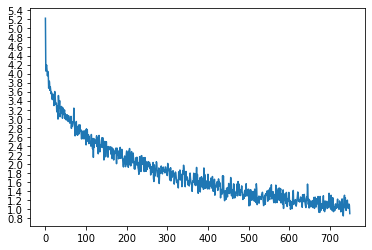

In [19]:
hidden_size = 256
encoder1 = EncodeRNN(input_lang.num_words, hidden_size).to(DEVICE)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.num_words, dropout_p=0.1).to(DEVICE)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [20]:
d = torch.randint(0,5,(10,300)).float()
d.size()

torch.Size([10, 300])

In [21]:
c = torch.randint(0,5,(1,1,300)).float()
c.size()

torch.Size([1, 1, 300])

In [22]:
s = F.softmax(torch.matmul(c, torch.t(d)),dim=2)
s

tensor([[[2.1705e-29, 0.0000e+00, 1.6038e-28, 1.0000e+00, 0.0000e+00,
          8.7565e-27, 4.0796e-41, 0.0000e+00, 0.0000e+00, 1.4013e-44]]])

In [23]:
new = torch.matmul(s,d)
new

tensor([[[2.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 4.8114e-28,
          2.0000e+00, 2.0000e+00, 3.5069e-26, 2.0000e+00, 2.6837e-26,
          2.0000e+00, 4.0758e-28, 4.0000e+00, 1.0000e+00, 2.0000e+00,
          4.0000e+00, 3.5208e-26, 3.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 2.6794e-26, 3.0000e+00, 3.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00,
          2.0000e+00, 4.0000e+00, 3.0000e+00, 2.6772e-26, 9.4414e-27,
          1.0000e+00, 4.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00,
          2.0000e+00, 4.0000e+00, 9.1424e-27, 8.7782e-27, 2.0000e+00,
          1.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
          2.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
          3.0000e+00, 4.0000e+00, 2.6677e-26, 2.0000e+00, 4.0000e+00,
          1.0000e+00, 6.5116e-29, 1.0000e+00, 7.0664e-28, 4.0000e+00,
          3.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 4.3410e-29,
          1.0000e+00